In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

In [2]:
# Example 10.2 on p252
# Access control task
class AccessControl():
    def __init__(self, free_prob=0.06, max_server=10):
        
        self.free_prob = free_prob
        self.max_server = max_server
    
    def init(self):
        self.n_free = self.max_server
        self.get_customer()
        return np.array([self.curr_customer, self.n_free])
        
    def get_customer(self):
        customer = np.random.choice([0,1,2,3])
        self.curr_customer = customer
    
    def step(self, action):
        
        # calculate servers to freed up
        busy = self.max_server - self.n_free
        freed = np.random.binomial(busy, self.free_prob)
        
        
        if action:
            # allocate server & return reward
            if self.n_free >= 1:
                self.n_free -= 1
                reward = 2**self.curr_customer
                
            # penalise when no serve is available
            else:
                reward = -1 
        else:
            reward = 0
        
        # free up server
        self.n_free += freed
        
        # generate next customer
        self.get_customer()
        
        return np.array([self.curr_customer, self.n_free]), reward

In [3]:
# average reward SARSA using tabular method
class AvgSARSA():
    def __init__(self, table, alpha, epsilon, rhat, beta):
        self.table = table
        self.alpha = alpha
        self.epsilon = epsilon
        
        self.rhat = rhat
        self.beta = beta
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice([0,1])
        else:
            return np.argmax(self.table[tuple(state)])
        
    def learn(self, env, iterations):
        state = env.init()
        action = self.act(state)
        for _ in range(iterations):
            # act & observe
            state_, reward = env.step(action)
            action_ = self.act(state_)

            # update
            self.table[tuple(state)][action] += self.alpha * (reward-self.rhat+self.table[tuple(state_)][action_]-self.table[tuple(state)][action])
            self.rhat += self.beta * (reward - self.rhat)
            
            # iterate
            state = state_
            action = action_

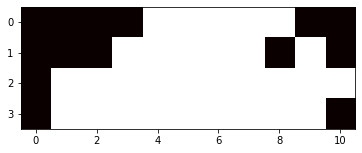

In [4]:
env = ServerAllocation()
agent = AvgSARSA(np.zeros((4,11,2)), 0.01, 0.1, 0., 0.01)
agent.learn(env, 100000)

policy = np.diff(agent.table, axis=-1).reshape(4,11) > 0
plt.imshow(policy, cmap='hot')
plt.show()

# figure 10.6